
The cardiovascular model can be expressed as a system of differential equations:
\begin{align*}
\frac{dV_{lv}}{dt} &= Q_{MV} - Q_{AV} \\
\frac{dV_{ao}}{dt} &= Q_{AV} - Q_{art\_sys}
\end{align*}

Where:
\begin{align*} 
Q_{MV} &= \max\left(\frac{P_{LA} - p_{lv}}{R_{MV}}, 0\right) \\ \\
 Q_{AV} &= \max\left(\frac{p_{lv} - p_{ao}}{R_{AV}}, 0\right) \\ \\
Q_{art\_sys} &= \frac{p_{ao} - P_{SysCap}}{R_{art}} \\ \\
p_{lv} &= E(t)(Vlv-V_d) \\ \\
p_{ao} &= \frac{V_{ao}}{C_{ao}}\\ \\
\end{align*}


The linear elastance function, which represents the muscle contraction in the heart, is expressed as:
$$E(t) = 
    \begin{cases} 
      \frac{(E_{max} - E_{min})}{2}\left(1 - \cos\left(\frac{\pi t}{ T_{peak}}\right)\right) + E_{min}, & \text{if } t \leq T_{peak} \\ \\
        \frac{(E_{max} - E_{min})}{2}\left(1 + \cos\left(\frac{\pi (t - T_{peak})}{(T_{relax} - T_{peak})}\right)\right) + E_{min}, & \text{if } t \leq T_{relax} \\ \\
      E_{min}, & \text{otherwise}
    \end{cases}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
def simple_CV_model(y,t, param):
    # Differential equations
    Vlv, Vao = y

    # Unpack parameters
    P_LeftAtr, P_SysCap, Rmv, Rav, Rsysart, Emax, Emin, T_peak, T_relax, T, Vlv_d, Cao = param

    # Get LV and Ao pressure
    plv = LinearElastance(Vlv, t, [Emax, Emin, Vlv_d, T_peak, T_relax, T])
    pao = Vao / Cao

    # Flows through valves and systemic arteries
    qmv = np.maximum(((P_LeftAtr - plv) / Rmv), 0.0)
    qav = np.maximum(((plv - pao) / Rav), 0.0)
    qcap = (pao - P_SysCap) / Rsysart

    # Update differential equations
    dVlv = qmv - qav
    dVsa = qav - qcap
    dY = [dVlv, dVsa]

    return dY

def LinearElastance(Vlv, t, params):
    Emax, Emin, Vlv_d, T_peak, T_relax, T = params
    
    # Modulate time to stay between 0 and T
    tmod = t % T

    # Define the piecewise elastance
    if tmod <= T_peak:
        E = (Emax - Emin) * (1 - np.cos(np.pi * tmod / T_peak)) / 2 + Emin
    elif tmod <= T_relax:
        E = (Emax - Emin) * (1 + np.cos(np.pi * (tmod - T_peak) / (T_relax - T_peak))) / 2 + Emin
    else:
        E = Emin

    return E*(Vlv-Vlv_d)


In [3]:
0.025%1

0.025

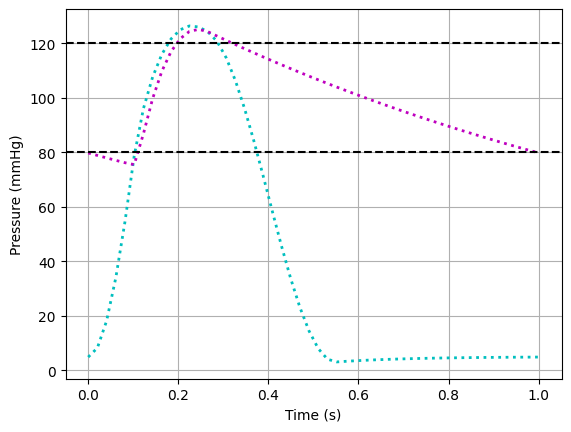

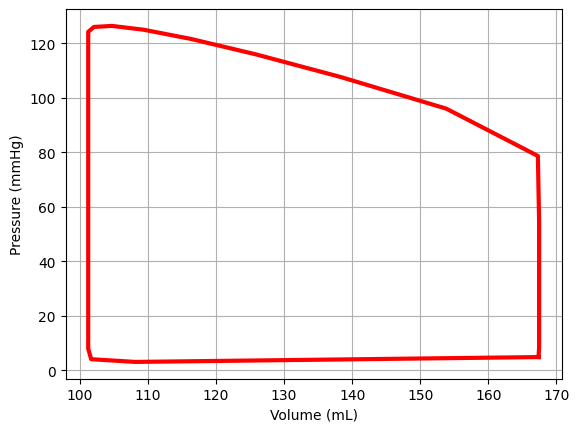

In [4]:


# Define the parameters for the system
P_LA = 5  # left atrial pressure (mmHg)
P_SysCap = 20  # systemic capillary pressure (mmHg)
Rmv = 5e-3  # resistance in the mitral valve (mmHg s/micro l)
Rav = 1e-2  # resistance in the aortic valve (mmHg s/micro l)
Rart = 1.2  # resistance of the systemic arteries/arterioles (mmHg s/ml)
Emax = 1.3  # End systolic elastance (mmHg/ml)
Emin = 0.03  # Nonlinear elastance term (1/ml)
T_peak = 0.25  # peak elastance (s)
T_relax = 0.55  # end of systole (s)
T = 1.0  # total cycle length
Cao = 1.1  # aortic compliance (ml s / mmHg)
Vlv_d = 5  # volume not ejected in the heart

# Stack all the parameters into a vector
param = [P_LA, P_SysCap, Rmv, Rav, Rart, Emax, Emin, T_peak, T_relax, T, Vlv_d, Cao]

# Volumes are in microliters
Vlv_init = 200  # LV Volume
Vao_init = 380  # Aortic Volume

# Starting and ending time
tstart = 0
tend = 30 * T  # 30 cycles
dt = 1e-3
tspace = np.arange(tstart, tend, dt)



# Initial conditions
X0 = [Vlv_init, Vao_init]

# Solve the system of ODEs
y = odeint(simple_CV_model, X0, tspace, args=(param,))

# We solved the model for 30 heartbeats; we want to extract the last one for plotting
tplot = np.linspace(29 * T - dt, 30 * T, 50)
Vlv = np.interp(tplot, tspace, y.T[0] )
Vao = np.interp(tplot, tspace, y.T[1] )

tplot = tplot - tplot[0]

# Extract the solutions to the two differential equations
# Vlv = yout[0]
# Vao = yout[1]

# Now, recompute the pressures and flows
plv = np.zeros((50,1))
for i in range(50):
    plv[i] = LinearElastance(Vlv[i], tplot[i], [Emax, Emin, Vlv_d, T_peak, T_relax, T])

pao = Vao / Cao
QMV = np.max((P_LA - plv) / Rmv, 0)
QAV = np.max((plv - pao) / Rav, 0)
Qart_sys = (pao - P_SysCap) / Rart

# Plotting
# Pressure
plt.figure(1); 
plt.plot(tplot, plv, ':c', linewidth=2)
plt.plot(tplot, pao, ':m', linewidth=2)
plt.axhline(y=120, color='k', linestyle='--')
plt.axhline(y=80, color='k', linestyle='--')
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Time (s)')
plt.grid(True)

# PV loop
plt.figure(2); 
plt.plot(Vlv, plv, 'r', linewidth=3)
plt.ylabel('Pressure (mmHg)')
plt.xlabel('Volume (mL)')
plt.grid(True)
plt.show()


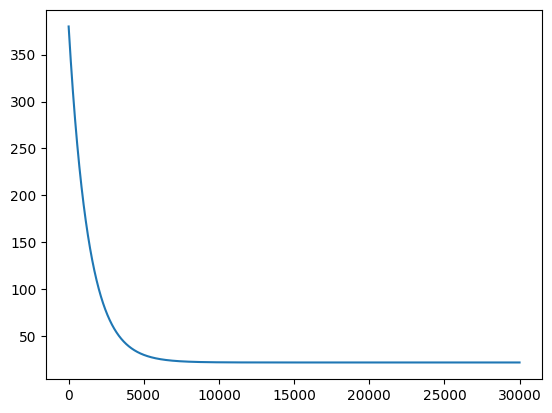